In [177]:
import os
import random
import numpy as np
import pickle

import matplotlib.pyplot as plt

In [105]:
import re
import spacy

import nltk
import string
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


In [109]:
bio_files_dir = '../data/bio_data_files'
bio_files = [os.path.join(bio_files_dir, f) for f in os.listdir('../data/bio_data_files') if f.endswith('.bio')]

In [110]:
print(f"The number of .bio files is {len(bio_files)}")

The number of .bio files is 200


## Check if any of the stopwords contain B-tag

In [111]:
for bio_file in bio_files:
    with open(bio_file, "r", encoding='utf-8') as f:
        for line in f:
            if line.strip() == '':
                continue
            word, tag = line.strip().split('\t')
            if word in STOP_WORDS and tag.startswith('B'):
                print(line)

## Data Cleaning

In [112]:
def clean_word(word):
    
    # remove non-alphanumeric characters and extra whitespaces
    word = re.sub(r'[^\w\s]','',word)
    word = re.sub(r'\s+',' ',word)
    
    # convert to lowercase
    word = word.lower()
    
    if word not in STOP_WORDS:
        return word
    
    return ''

In [113]:
# Load a pre-trained Spacy model and set the stop words
nlp = spacy.load('en_core_web_sm')

def clean_word(word):
    # remove non-alphanumeric characters and extra whitespaces
    word = re.sub(r'[^\w\s]','',word)
    word = re.sub(r'\s+',' ',word)
    
    # convert to lowercase
    word = word.lower()

    # lemmatize the word
    lemma = nlp(word)[0].lemma_
    
    # check if the lemma is a stop word
    if lemma not in STOP_WORDS:
        return lemma
    
    return ''


In [114]:
def parse_data_from_file(bio_file):
    """
    Reads a file in BIO format (one token per line, with tab-separated word and tag),
    and extracts the sentences and labels as lists of lists. Each inner list represents
    a sentence, and contains the words of the sentence in order. Each corresponding inner
    list in the 'labels' list contains the BIO tags for the words in the corresponding
    sentence, in the same order.
    
    Args:
    - bio_file (str): the path to the BioNLP file to read
    
    Returns:
    - A tuple containing:
        - sentences (List[List[str]]): a list of lists, where each inner list represents
          a sentence and contains the words of the sentence in order
        - labels (List[List[str]]): a list of lists, where each inner list corresponds
          to a sentence in the 'sentences' list and contains the BIO tags for the words
          in the corresponding sentence, in the same order.
    """
    sentences = []
    labels = []
    
    with open(bio_file, "r", encoding='utf-8') as f:
        
        current_sentences = []
        current_labels = []
        
        for line in f:
            
            if line.strip() == '':
                # If we encounter a blank line, it means we've reached the end of a sentence
                if len(current_sentences) > 0:
                    
                    # Add the current sentence and labels to the list
                    sentences.append(current_sentences)
                    labels.append(current_labels)
                    
                    # Reset the current sentence and labels lists
                    current_sentences = []
                    current_labels = []
                    continue
                    
            word, tag = line.strip().split('\t')
            word = clean_word(word)
            
            if word.strip():
                current_sentences.append(word)
                
                if len(current_labels) > 0:
                    if tag[2:] == current_labels[-1][2:] and tag[:2] == "B-":
                        tag = f"I-{tag[2:]}"
                current_labels.append(tag)
        
    return sentences, labels

In [115]:
def parse_bio_files(bio_files):
    
    sentences = []
    labels = []
    
    for idx, bio_file in enumerate(bio_files):
        
        curr_sentences, curr_labels = parse_data_from_file(bio_file)
        
        if len(curr_sentences) > 0:
            sentences.extend(curr_sentences)
            labels.extend(curr_labels)
            
        if (idx+1) % 20 == 0:
            print(f'{idx+1} completed')

    return sentences, labels

In [63]:
sentences, labels = parse_bio_files(bio_files)

20 completed
40 completed
60 completed
80 completed
100 completed
120 completed
140 completed
160 completed
180 completed
200 completed


In [116]:
print(f"Dataset contains {len(sentences)} examples\n")

Dataset contains 4341 examples



## Shuffle the sentences and labels

In [117]:
combined = list(zip(sentences, labels))
random.shuffle(combined)
sentences[:], labels[:] = zip(*combined)

## Train Test Validation Split

In [118]:
# Split the data into training, validation, and test sets

TEST_SIZE = 0.2

num_sentences = len(sentences)
num_train = int(num_sentences * (1 - TEST_SIZE - 0.1))
num_valid = int(num_sentences * 0.1)

In [143]:
train_sentences = sentences[:num_train]
train_labels = labels[:num_train]

valid_sentences = sentences[num_train:num_train+num_valid]
valid_labels = labels[num_train:num_train+num_valid]

test_sentences = sentences[num_train+num_valid:]
test_labels = labels[num_train+num_valid:]

## Tokenization - Sequences and padding

In [144]:
unique_labels = set(element for sublist in labels for element in sublist)

In [145]:
label_to_index = {label: id+1 for id, label in enumerate(sorted(unique_labels))}
index_to_label = {id: label for label, id in label_to_index.items()}

In [146]:
# Add the new label and ID to the dictionaries
label_to_index['<PAD>'] = 0
index_to_label[0] = '<PAD>'

In [147]:
NUM_CLASSES = len(index_to_label)

In [148]:
MAX_LENGTH = 100

train_labels = [[label_to_index[label] for label in labels] for labels in train_labels]
train_labels = pad_sequences(train_labels, maxlen=MAX_LENGTH, padding='post', value=NUM_CLASSES-1)
train_labels = to_categorical(train_labels, num_classes=NUM_CLASSES)

valid_labels = [[label_to_index[label] for label in labels] for labels in valid_labels]
valid_labels = pad_sequences(valid_labels, maxlen=MAX_LENGTH, padding='post', value=NUM_CLASSES-1)
valid_labels = to_categorical(valid_labels, num_classes=NUM_CLASSES)

test_labels = [[label_to_index[label] for label in labels] for labels in test_labels]
test_labels = pad_sequences(test_labels, maxlen=MAX_LENGTH, padding='post', value=NUM_CLASSES-1)
test_labels = to_categorical(test_labels, num_classes=NUM_CLASSES)

In [149]:
# Convert the input sentences to sequences of word indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)


train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(valid_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)


# Pad the sequences to a fixed length
train_sequences_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
val_sequences_padded = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
test_sequences_padded = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

###  save to a .npz file:

In [176]:
np.savez(
    '../data/data.npz',
     train_sequences_padded=train_sequences_padded,
     train_labels=train_labels,
     val_sequences_padded=val_sequences_padded,
     val_labels=valid_labels,
     test_sequences_padded=test_sequences_padded,
     test_labels=test_labels,
     label_to_index=label_to_index,
     index_to_label=index_to_label
)

## Building Model

In [150]:
train_labels.shape

(3038, 100, 79)

Epoch 1/20
95/95 [==============================] - 8s 63ms/step - loss: 0.8827 - accuracy: 0.8964 - val_loss: 0.3796 - val_accuracy: 0.9129
Epoch 2/20
95/95 [==============================] - 6s 64ms/step - loss: 0.3871 - accuracy: 0.9065 - val_loss: 0.3668 - val_accuracy: 0.9130
Epoch 3/20
95/95 [==============================] - 6s 62ms/step - loss: 0.3634 - accuracy: 0.9086 - val_loss: 0.3585 - val_accuracy: 0.9149
Epoch 4/20
95/95 [==============================] - 6s 63ms/step - loss: 0.3383 - accuracy: 0.9138 - val_loss: 0.3494 - val_accuracy: 0.9180
Epoch 5/20
95/95 [==============================] - 6s 65ms/step - loss: 0.3026 - accuracy: 0.9217 - val_loss: 0.3306 - val_accuracy: 0.9253
Epoch 6/20
95/95 [==============================] - 6s 65ms/step - loss: 0.2605 - accuracy: 0.9332 - val_loss: 0.3159 - val_accuracy: 0.9305
Epoch 7/20
95/95 [==============================] - 6s 63ms/step - loss: 0.2212 - accuracy: 0.9435 - val_loss: 0.3047 - val_accuracy: 0.9337
Epoch 8/20
95

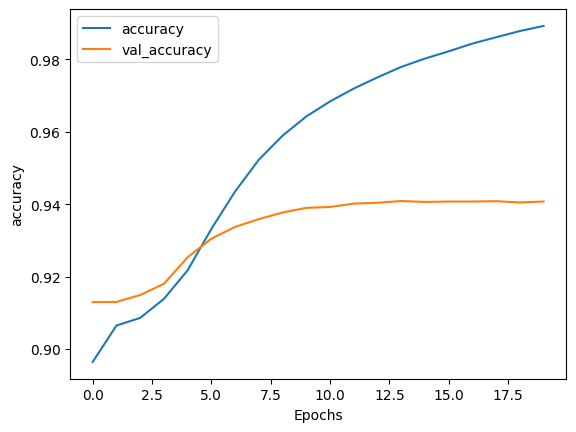

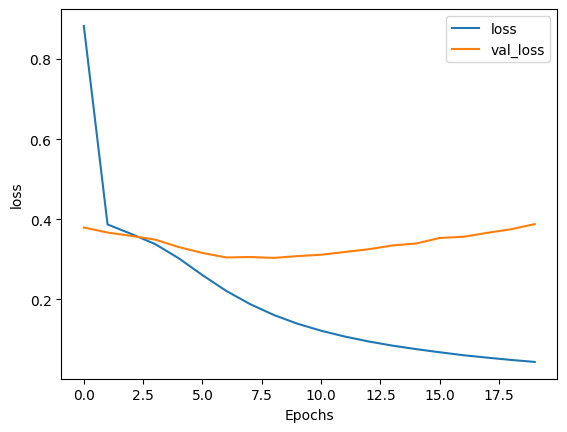

28/28 [==============================] - 0s 17ms/step - loss: 0.4221 - accuracy: 0.9364
Test accuracy: 0.9364326596260071


1/1 [==============================] - 0s 9ms/step
Predicted Named Entities:
leptospira: Diagnostic_procedure
igm: Diagnostic_procedure
antibody: O
perform: Date
5th: Date
day: O
illness: Lab_value
positive: Diagnostic_procedure
igg: Lab_value
negative: O


In [180]:
# Assuming tokenizer is your trained tokenizer
with open('../data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)